In [1]:
import json
import copy

import numpy
import matplotlib
from matplotlib import pyplot
import pyhf

import blind
import jsongz

In [2]:
import jax
import scipy.optimize

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)
pyhf.set_backend("jax")

In [3]:
SPEC = jsongz.load("ins1852821_bkg.json.gz")
# SPEC = jsongz.load("ins1852821_signal.json.gz")

In [4]:
[channel["name"] for channel in SPEC["channels"]]

['SR0bvetoloose_cuts',
 'SR0bvetotight_cuts',
 'SR0breq_cuts',
 'SR1bvetoloose_cuts',
 'SR1bvetotight_cuts',
 'SR1breq_cuts',
 'SR2bvetoloose_cuts',
 'SR2bvetotight_cuts',
 'SR2breq_cuts',
 'SR0ZZloose_cuts',
 'SR0ZZtight_cuts',
 'SR0ZZbvetoloose_cuts',
 'SR0ZZbvetotight_cuts',
 'SR5L_cuts',
 'CRZZ_cuts',
 'CRttZ_cuts']

In [5]:
SR_NAME = "SR0bvetotight_cuts"
# SR_NAME = "SR0ZZloose_cuts"
# SR_NAME = "SR0ZZtight_cuts"
# SR_NAME = "SR0ZZbvetotight_cuts"
# atlas_susy_4l presents yields without SR constraints
# (sensibly, but violating ATLAS SUSY policy)

In [6]:
CHANNEL_NAMES = {
    SR_NAME,
    "CRZZ_cuts",
    "CRttZ_cuts",
}

In [7]:
POI_NAME = "mu_ZZ"

In [8]:
def get_named(seq, name):
    for item in seq:
        if item["name"] == name:
            return item
    raise KeyError(name)

In [9]:
def select_channels(spec, channel_names):
    channels = spec["channels"]
    spec["channels"] = [
        channel
        for channel in channels
        if channel["name"] in channel_names
    ]
    return spec


def clear_poi(spec):
    for measurement in spec["measurements"]:
        measurement["config"]["poi"] = ""
    return spec

In [10]:
def make_model_and_data(spec, poi_name, channel_names):
    spec = copy.deepcopy(spec)
    spec = select_channels(spec, channel_names)
    spec = clear_poi(spec)
    
    workspace = pyhf.workspace.Workspace(spec)
    
    channels_prune = workspace.channel_slices.keys() - channel_names
    
    workspace_pruned = workspace.prune(channels=channels_prune)
    
    model = workspace_pruned.model()
    data = numpy.array(workspace_pruned.data(model))
    return model, data


MODEL, DATA = make_model_and_data(SPEC, POI_NAME, CHANNEL_NAMES)

In [11]:
def test_logpdf(model, data, signal_channel_name):
    parameters = numpy.array(model.config.suggested_init())
    
    print(model.logpdf(parameters, data))
    
    print(blind.model_logpdf_blind(model, parameters, data, []))
    
    logf = blind.model_logpdf_blind(model, parameters, data, {signal_channel_name})
    print(logf)

    slice_ = model.config.channel_slices[signal_channel_name]
    expected_data = model.expected_actualdata(parameters)
    mu = expected_data[slice_]
    nobs = data[slice_]
    print(mu, nobs)

    loglikelihood = pyhf.probability.Poisson(mu).log_prob(numpy.array(nobs))
    print(loglikelihood)
    print(logf + loglikelihood)


test_logpdf(MODEL, DATA, SR_NAME)

[-105.12972977]
[-105.12972977]
[-102.92482288]
[3.4405334] [1.]
[-2.20490689]
[-105.12972977]


In [12]:
def test_hess():
    def f(x):
        return 0.5 * x ** 2
    
    print(jax.hessian(f)(0.1))
    
test_hess()

1.0


In [13]:
def inner_product(x, c):
    return x.dot(c.dot(x))

In [14]:
def d2fdx2(fminus, f, fplus, eps):
    return ((fplus - f) - (f - fminus)) / eps ** 2

In [15]:
def test_opt(model, data, signal_channel_name):
    blind_bins = {signal_channel_name}
    
    def f(x):
        logy, = blind.model_logpdf_blind(model, x, data, blind_bins)
        return -logy
    
    fjit = jax.jit(jax.value_and_grad(f))
          
    parameters = numpy.array(model.config.suggested_init())
    bounds = numpy.array(model.config.suggested_bounds())
    
    print(fjit(parameters)[0])

    result = scipy.optimize.minimize(
        fjit,
        parameters,
        bounds=bounds,
        jac=True,
        method="L-BFGS-B",
        options=dict(ftol=1e-10, gtol=1e-10),
    )
    
    print(result)
    
    # SR yields
    slice_ = model.config.channel_slices[signal_channel_name]
    
    def y(x):
        expected_data = model.expected_actualdata(x)
        yres, = expected_data[slice_]
        return yres
    
    print(y(parameters))
    print(y(result.x))
    
    ygrad = jax.grad(y)(result.x)
    
    def cov_jax(x):
        hess = jax.hessian(f)(x)
        return jax.numpy.linalg.inv(hess)
    
    cov_lbfgs = result.hess_inv.todense()
    cov = numpy.array(cov_jax(result.x))
    
    var_lbfgs = inner_product(ygrad, result.hess_inv)
    var = inner_product(ygrad, cov)
    
    print("std")
    print(var_lbfgs ** 0.5)
    # jax hessian is better now we have no unused parameters :)
    print(var ** 0.5)


test_opt(MODEL, DATA, SR_NAME)

102.92482288151945
      fun: 81.11213901403168
 hess_inv: <97x97 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.79088556e-05,  6.17421128e-06,  2.28929389e-06, -8.22721353e-06,
       -1.00153606e-05, -1.07198219e-06,  4.22216918e-06, -8.04890524e-07,
       -5.28586243e-05,  3.24974300e-06,  9.93245876e-06, -1.02503663e-05,
        5.73597117e-06,  2.86205760e-08,  2.53831131e-06, -1.18912132e-06,
       -6.71268788e-08, -1.77371195e-08,  4.14936555e-05, -2.75563030e-05,
        2.52029053e-05,  8.59481842e-06,  8.30866199e-06,  4.77005158e-07,
        1.96746410e-05,  0.00000000e+00,  1.46909572e-05,  3.46092799e-05,
       -4.26945060e-06,  5.30018679e-06, -2.42391605e-06,  9.26010782e-09,
        5.50327811e-06,  1.55940927e-08, -1.35202806e-06, -4.05940361e-06,
       -2.30705978e-10, -2.22549809e-10,  1.39915057e-09, -2.92133956e-08,
       -4.26041110e-08,  2.80860030e-08, -1.46050662e-09,  2.57853518e-08,
       -2.76950697e-09,  1.30900036e-09,  1.68871051e-05, 

# optimize with constraints

In [16]:
def piecewise_linear_roots(f, x):
    """Return a list of points for which f(x) = 0 in a linear interpolation."""
    results = []
    for f1, f2, x1, x2 in zip(f[:-1], f[1:], x[:-1], x[1:]):
        # root implies that f1 f2 change sign
        if not f1 * f2 <= 0:
            continue
        # zero step special case
        if x1 == x2:
            if f1 == 0:
                results.append(x1)
            continue
        # zero change special case
        if f1 == f2:
            if f1 == 0:
                # panic! entire line segment is a root
                results.append(numpy.nan)
            continue
        # approx f = f1 + (x - x1) * (f2 - f1) / (x2 - x1)
        #          = f1 + (x - x1) * dfdx
        # f = 0 =>
        #        x = x1 + (0 - f1) / dfdfx
        xroot = x1 - f1 * (x2 - x1) / (f2 - f1)
        results.append(xroot)
    return results

f =  81.11213909735622
y =  3.5235415438600377
f =  81.13599101655853
y =  3.999999939654941
1.9165886285355695 6.166153610215982
0.0 85.49325851944684
1.0 83.30647739395523
2.0 81.54602664229294
3.0 81.14895411729808
4.0 81.13599101655853
5.0 81.30044338951352
6.0 81.56220113186767
7.0 81.88325410097742
8.0 82.24295546528128
9.0 82.62898760253137
10.0 83.03349209079842
11.0 83.45119771285663
12.0 83.87843123370459
13.0 84.31255246283378
14.0 84.75161783462603
15.0 85.194167960408
16.0 85.63908813422043
17.0 86.08551647761328
18.0 86.53277750330327
19.0 86.9803384556309
20.0 87.427776343381


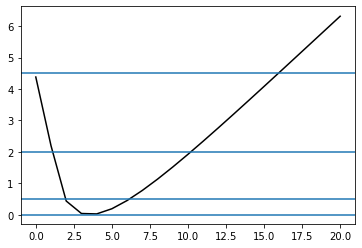

/tmp/ipykernel_41768/2945315957.py:129: RuntimeWarning: divide by zero encountered in log
  pyplot.plot(numpy.log(ypoints), fs - result.fun, "k")


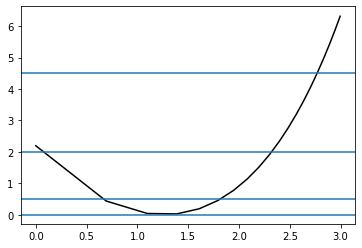

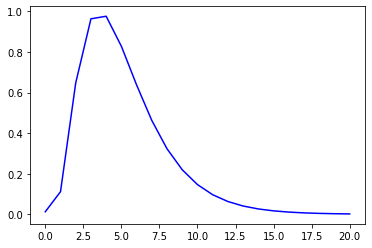

[1.962445723062204, 6.155544319141558]


In [17]:
def test_opt_constrain(model, data, signal_channel_name):
    blind_bins = {signal_channel_name}
    
    # optimization
    def f(x):
        logy, = blind.model_logpdf_blind(model, x, data, blind_bins)
        return -logy
    
    fjit = jax.jit(jax.value_and_grad(f))
          
    parameters = numpy.array(model.config.suggested_init())
    bounds = numpy.array(model.config.suggested_bounds())
    
    result = scipy.optimize.minimize(
        fjit,
        parameters,
        bounds=bounds,
        jac=True,
        method="L-BFGS-B",
    )
    
    # SR yields
    slice_ = model.config.channel_slices[signal_channel_name]
    
    def y(x):
        expected_data = model.expected_actualdata(x)
        yres, = expected_data[slice_]
        return yres
    
    yjit = jax.jit(y)
    
    print("f = ", result.fun)
    print("y = ", yjit(result.x))
    
    # constrain
    ygrad = jax.jit(jax.grad(y))
    
    yfix = 4.0
    fix = scipy.optimize.NonlinearConstraint(y, yfix, yfix, jac=ygrad)
        
    result2 = scipy.optimize.minimize(
        fjit,
        parameters,
        bounds=bounds,
        jac=True,
        method="SLSQP",
        constraints=fix,
    )

    print("f = ", result2.fun)
    print("y = ", yjit(result2.x))
    
    # solve for thresholds
    ybothgradjit = jax.jit(jax.value_and_grad(y))
    fvaluejit = jax.jit(f)
    fgradjit = jax.jit(jax.grad(f))
    
    def yminmax_given_ffix(ffix):
        fix = scipy.optimize.NonlinearConstraint(
            fvaluejit, 
            ffix, 
            ffix, 
            jac=fgradjit,
        )
        
        result_lo = scipy.optimize.minimize(
            ybothgradjit,
            parameters,
            bounds=bounds,
            jac=True,
            method="SLSQP",
            constraints=fix,
        )
        
        def ymax(x):
            value, grad = ybothgradjit(x)
            return -value, -grad
        
        result_hi = scipy.optimize.minimize(
            ymax,
            parameters,
            bounds=bounds,
            jac=True,
            method="SLSQP",
            constraints=fix,
        )
        
        return result_lo.fun, -result_hi.fun
    
    lo, hi = yminmax_given_ffix(result.fun + 0.5)
    print(lo, hi)

    # scan
    def fmin_given_yfix(yfix):
        fix = scipy.optimize.NonlinearConstraint(
            y, 
            yfix, 
            yfix, 
            jac=ygrad,
        )

        result = scipy.optimize.minimize(
            fjit,
            parameters,
            bounds=bounds,
            jac=True,
            method="SLSQP",
            constraints=fix,
        )
        
        return result.fun
    
    ypoints = numpy.linspace(0., 20., 21)
    
    fs = []
    for yfix in ypoints:
        fmin = fmin_given_yfix(yfix)
        print(yfix, fmin)
        fs.append(fmin)
        
    fs = numpy.array(fs)
    
    pyplot.plot(ypoints, fs - result.fun, "k")
    for sigma in (0, 1, 2, 3):
        fsigma = 0.5 * sigma ** 2
        pyplot.axhline(fsigma)
    pyplot.show()   
    
    pyplot.plot(numpy.log(ypoints), fs - result.fun, "k")
    for sigma in (0, 1, 2, 3):
        fsigma = 0.5 * sigma ** 2
        pyplot.axhline(fsigma)
    pyplot.show()
    
    pyplot.plot(ypoints, numpy.exp(result.fun - fs), "b")
    pyplot.show()   
    
    print(piecewise_linear_roots(fs - result.fun - 0.5, ypoints))
    

test_opt_constrain(MODEL, DATA, SR_NAME)

In [18]:
def print_fit_stuff():
    lo, hi = 2.0101597853190163, 6.4773782077039534
    mid = 3.52361816023076
    
    err_lo = lo - mid
    err_hi = hi - mid
    print("%.1f %+.1f %+.1f" % (mid, err_hi, err_lo))

print_fit_stuff()

3.5 +3.0 -1.5


# cabinetry

In [19]:
import cabinetry
import logging
import io

from contextlib import contextmanager

In [20]:
@contextmanager
def capture_log(log, level=logging.INFO):
    """Gather logginfo from log into a buffer in this context."""
    buffer = io.StringIO()
    handler = logging.StreamHandler(buffer)
    
    level_old = log.level
    propagate_old = log.propagate
    log.setLevel(level)
    log.addHandler(handler)
    log.propagate = False
    
    try:
        yield buffer
    finally:
        log.setLevel(level_old)
        log.removeHandler(handler)
        log.propagate = propagate_old


def cabinetry_yields_table(prediction, data):
    with capture_log(cabinetry.tabulate.log) as buffer:
        cabinetry.tabulate.yields(prediction, data)    
    return buffer.getvalue()

In [21]:
def fit_cabinetry(model, data):
    fit_results = cabinetry.fit.fit(model, data)

    postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)

    table_postfit = cabinetry_yields_table(postfit, data)
    print(table_postfit)

fit_cabinetry(MODEL, DATA)

yields per bin for post-fit model prediction:
╒════════════════════╤═════════════════╤══════════════╤══════════════════════╕
│ sample             │ CRZZ_cuts       │ CRttZ_cuts   │ SR0bvetotight_cuts   │
│                    │ bin 1           │ bin 1        │ bin 1                │
╞════════════════════╪═════════════════╪══════════════╪══════════════════════╡
│ MG5Py8_4t          │ 0.00            │ 0.12         │ 0.00                 │
├────────────────────┼─────────────────┼──────────────┼──────────────────────┤
│ MG5Py8_tZ_3l       │ 0.00            │ 0.01         │ 0.00                 │
├────────────────────┼─────────────────┼──────────────┼──────────────────────┤
│ MG5Py8_ttXX        │ 0.01            │ 0.74         │ 0.01                 │
├────────────────────┼─────────────────┼──────────────┼──────────────────────┤
│ PowHegPy8_WH       │ 0.05            │ 0.01         │ 0.00                 │
├────────────────────┼─────────────────┼──────────────┼──────────────────────┤
│ PowH

In [22]:
MODEL_NO_SR, DATA_NO_SR = make_model_and_data(SPEC, POI_NAME, {"CRZZ_cuts", "CRttZ_cuts"})

In [23]:
def fit_cabinetry_no_sr(model_no_sr, data_no_sr, model, data):
    fit_results_no_sr = cabinetry.fit.fit(model_no_sr, data_no_sr)
    fit_results = cabinetry.fit.fit(model, data)
    
    fit_results_vr = cabinetry.model_utils.match_fit_results(model, fit_results_no_sr)

    prefit = cabinetry.model_utils.prediction(model, fit_results=fit_results_vr)
    print(prefit)
    print(numpy.sum(prefit.model_yields, axis=(1, 2)))
    table_prefit = cabinetry_yields_table(prefit, data)
    print(table_prefit)
    
    postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)
    
    table_postfit = cabinetry_yields_table(postfit, data)
    print(table_postfit)


fit_cabinetry_no_sr(MODEL_NO_SR, DATA_NO_SR, MODEL, DATA)

ModelPrediction(model=<pyhf.pdf.Model object at 0x7f78a013fd00>, model_yields=[[[0.0], [0.0017450382442892017], [0.011749028444414665], [0.04847772696016533], [0.5432347059955037], [0.002215784236365955], [0.01702226118890966], [51.113280241988086], [21.29454172969963], [2302.8801259919933], [178.23967907412245], [0.488926253576734], [0.15968841913619736]], [[0.11771417601453919], [0.00998088797954614], [0.7382586271165797], [0.012333186232736168], [0.03112120447899264], [0.01463350652584426], [1.5318298427923356], [9.572208897027291], [0.9906692910170196], [1.0070482412443482], [0.054242984353553195], [41.16322182512556], [6.759086763206892]], [[0.0031622416268374154], [0.0], [0.008883028948953972], [0.0004617457198707693], [0.00815058933355714], [0.000563609925966262], [0.010375995599574148], [2.6029763678587643], [0.21077362360817653], [0.6329836778606057], [0.002728988707027682], [0.020295650921750803], [0.019759399536498017]]], total_stdev_model_bins=[[50.538170775336255], [7.8558

# TODO: minimal reproduction for 4L
# TODO: extract SR yields only
# TODO: print all (not wrong CRs for  5L)